In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from prophet import Prophet
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [141]:
# Load the dataset
file_path = "datasetupdated.csv"  # Change this if the file is in a different location
df = pd.read_csv(file_path)




In [142]:
# Ensure 'YEAR' column is in datetime format
df["YEAR"] = pd.to_datetime(df["YEAR"], format="%Y")

# Aggregate total cases reported per year
yearly_trend = df.groupby("YEAR")["CasesReported"].sum()



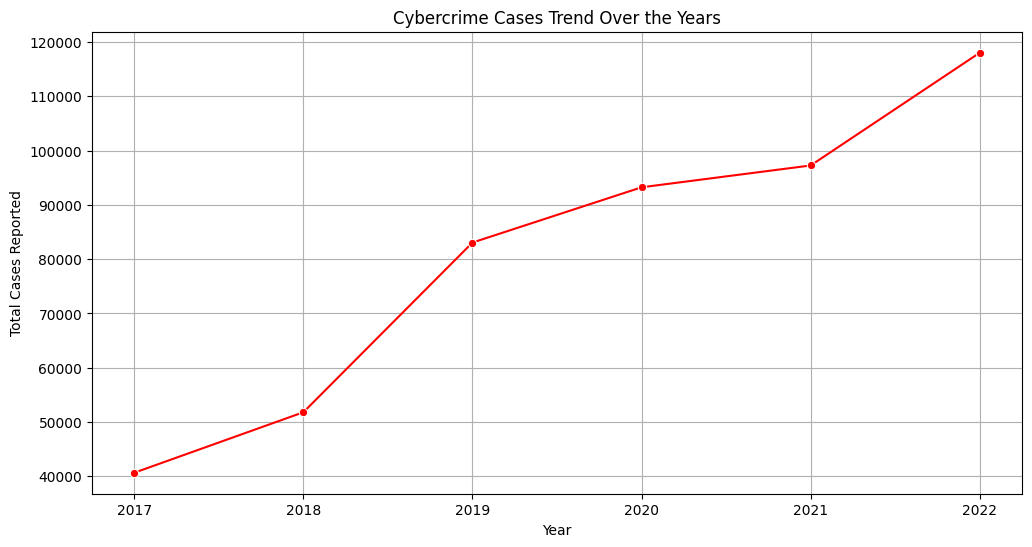

In [143]:
# Plot the time series trend
plt.figure(figsize=(12, 6))
sns.lineplot(x=yearly_trend.index.year, y=yearly_trend.values, marker="o", color="red")

# Formatting the plot
plt.xlabel("Year")
plt.ylabel("Total Cases Reported")
plt.title("Cybercrime Cases Trend Over the Years")
plt.grid()
plt.show()

In [144]:
# Step 1: Load the Data
yearly_cases = df.groupby("YEAR")["CasesReported"].sum().reset_index()

# Step 2: Convert Year to Datetime and Extract Only the Year
yearly_cases["YEAR"] = pd.to_datetime(yearly_cases["YEAR"], format="%Y").dt.year
yearly_cases["ds"] = pd.to_datetime(yearly_cases["YEAR"], format="%Y") 
# Ensure 'YEAR' is converted to datetime before extracting year
#yearly_cases["YEAR"] = pd.to_datetime(yearly_cases["YEAR"], format="%Y")


In [145]:
print(yearly_cases["YEAR"] )

0    2017
1    2018
2    2019
3    2020
4    2021
5    2022
Name: YEAR, dtype: int32


In [146]:

yearly_cases["YEAR"] = yearly_cases["YEAR"].astype(int)

# 📌 Step 2: Train the ARIMA Model
# Select only numeric values for modeling
time_series = yearly_cases.set_index("YEAR")["CasesReported"]

# Auto ARIMA to find the best parameters
arima_model = auto_arima(
    time_series,
    seasonal=False,
    stepwise=True,
    trace=True,
    d=1  # Force differencing to capture trends
)


# 📌 Step 3: Forecast Future Cases (5 Years Ahead)
n_forecast = 5
last_year = yearly_cases["YEAR"].max()  # Get last recorded year
future_years = list(range(last_year + 1, last_year + n_forecast + 1))  # 2023-2027

# Make Predictions
forecast_arima = arima_model.predict(n_periods=n_forecast)

# Convert forecast to DataFrame
arima_forecast_df = pd.DataFrame({
    "YEAR": future_years,  # Ensure correct years
    "CasesReported": forecast_arima  # Ensure column name matches actual dataset
})


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=109.824, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=111.111, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=114.323, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.379 seconds


C:\Users\sampu\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [154]:
print(df.tail(5))  # Last 5 years of data


          YEAR  Cases Pending Investigation from Previous Year (Col.4)  \
265 2022-01-01                                                 42        
266 2022-01-01                                                 30        
267 2022-01-01                                                122        
268 2022-01-01                                                 13        
269 2022-01-01                                                121        

     CasesReported  Cases Reopened for Investigation (Col.6)  \
265             37                                         0   
266              6                                         0   
267             27                                         0   
268             14                                         0   
269            103                                         7   

     Total Cases for Investigation (Col.7=Col.4+ Col.5+ Col.6)  \
265                                                 79           
266                                   

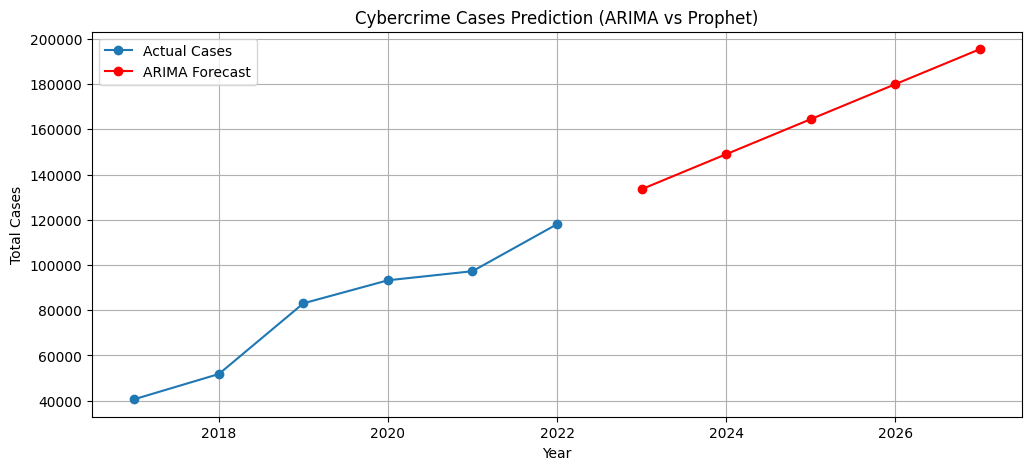

In [147]:
# 📌 Step 5: Visualization
plt.figure(figsize=(12, 5))

# Plot actual cases (UNCOMMENT THIS)
plt.plot(yearly_cases["YEAR"], yearly_cases["CasesReported"], marker="o", linestyle="-", label="Actual Cases")

# Plot ARIMA forecast correctly on timeline (CORRECTED COLUMN NAME)
plt.plot(arima_forecast_df["YEAR"], arima_forecast_df["CasesReported"], color="red", label="ARIMA Forecast", marker="o")

# Labels and Title
plt.xlabel("Year")
plt.ylabel("Total Cases")
plt.title("Cybercrime Cases Prediction (ARIMA vs Prophet)")
plt.legend()
plt.grid()

# Show the corrected plot
plt.show()


In [148]:
# ✅ Step 2: Prepare Prophet Data (No need to convert 'ds' to integer!)
prophet_df = yearly_cases.rename(columns={"ds": "ds", "CasesReported": "y"})

# ✅ Step 3: Fit Prophet Model
model = Prophet()
model.fit(prophet_df)

# ✅ Step 4: Create Future DataFrame (Ensure 'ds' is in datetime format)
future = model.make_future_dataframe(periods=5, freq="Y")  # Predict next 5 years

# ✅ Step 5: Make Predictions
forecast = model.predict(future)

16:04:58 - cmdstanpy - INFO - Chain [1] start processing
16:04:58 - cmdstanpy - INFO - Chain [1] done processing


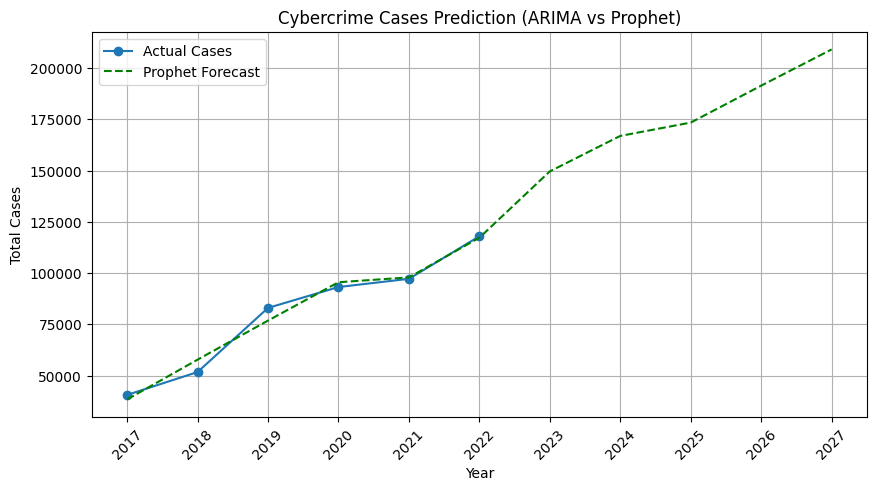

In [149]:
plt.figure(figsize=(10, 5))
plt.plot(prophet_df["ds"], prophet_df["y"], 'o-', label="Actual Cases")  # Use correct dataset
plt.plot(forecast["ds"], forecast["yhat"], 'g--', label="Prophet Forecast")
plt.xlabel("Year")
plt.ylabel("Total Cases")
plt.title("Cybercrime Cases Prediction (ARIMA vs Prophet)")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


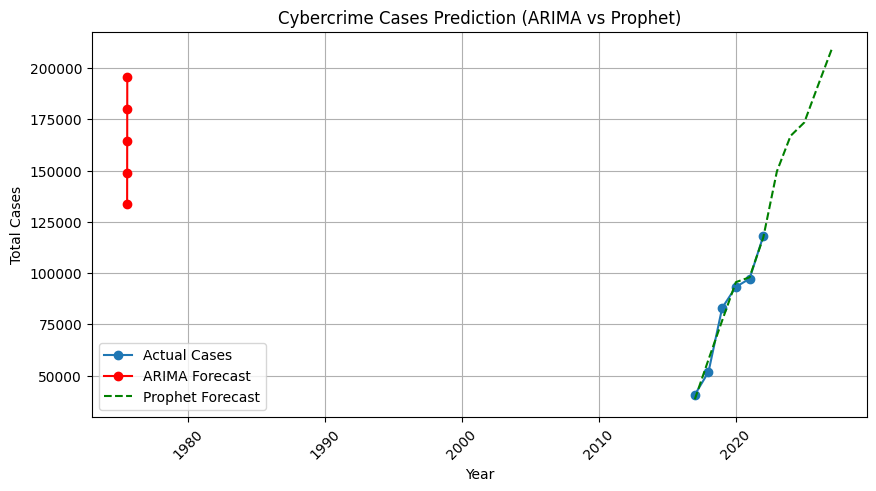

In [150]:
plt.figure(figsize=(10, 5))
plt.plot(prophet_df["ds"], prophet_df["y"], 'o-', label="Actual Cases")  # Use correct dataset

# Plot ARIMA forecast correctly on timeline (CORRECTED COLUMN NAME)
plt.plot(arima_forecast_df["YEAR"], arima_forecast_df["CasesReported"], color="red", label="ARIMA Forecast", marker="o")
plt.plot(forecast["ds"], forecast["yhat"], 'g--', label="Prophet Forecast")
plt.xlabel("Year")
plt.ylabel("Total Cases")
plt.title("Cybercrime Cases Prediction (ARIMA vs Prophet)")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


In [151]:
print(prophet_df.head())  # Ensure y values are correct



   YEAR      y         ds
0  2017  40647 2017-01-01
1  2018  51789 2018-01-01
2  2019  83050 2019-01-01
3  2020  93230 2020-01-01
4  2021  97251 2021-01-01


In [152]:

print(arima_forecast_df)




    YEAR  CasesReported
6   2023       133497.0
7   2024       148972.0
8   2025       164447.0
9   2026       179922.0
10  2027       195397.0
